In [1]:
import json
import os
import fnmatch
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import sys

%matplotlib inline
sns.set()

## Read in data

In [2]:
%%time

if os.sys.platform == 'win32':
    data_path = os.path.normpath(r'C:\Users\msladkov\Dropbox\Projects\activity-maps\berlin-data')
else:
    data_path = os.path.normpath(r'/Users/sladkovm/Dropbox/Projects/activity-maps/berlin-data/')
    
file_list = [file for file in os.listdir(data_path) if fnmatch.fnmatch(file, 'activity-*.json')]

keys = ['max_speed','commute','distance','has_heartrate','average_speed','device_watts', 'id']

data_list = []
for file in file_list:
    f_name = os.path.join(data_path, file)
    with open(f_name, 'r', encoding='utf-8') as f:
        content = json.load(f)
        res = {}
        for k in keys:
            try:
                res[k]=content[k]
            except:
                res[k] = np.nan
        data_list.append(res)
        
df = pd.DataFrame(data_list)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8678 entries, 0 to 8677
Data columns (total 7 columns):
average_speed    8678 non-null float64
commute          8678 non-null bool
device_watts     8678 non-null bool
distance         8678 non-null float64
has_heartrate    8678 non-null bool
id               8678 non-null int64
max_speed        8678 non-null float64
dtypes: bool(3), float64(3), int64(1)
memory usage: 364.4 KB
CPU times: user 1.1 s, sys: 573 ms, total: 1.67 s
Wall time: 2.17 s


## Split data into Model and Not Categorized set

All activities labeled as *commute* are treated as a ground truth set **Commute**

In order to get a ground truth **Training** set we will make an assumption that all activities with *device_watts* and not labeled as *commute* are the actual training activities.

The rationale behind this assumption is simple - the powermeter is expensive piece of equipment and those people, who have it, most likely use it for training. For those situations where one would go to work via the training route and will come back via the commute route (as I often do) we rely on the deligence of the riders to label the return route as a commute (as I do).

With these two assumptions at hand we can extract a model set from the given data, fit the classifier on this data set and use the classifier to label the rest of the data.

Stepwise actions:
* find all activivities labeled as commute and labels them as 'c'
* find all activities with powermeter, but labeled as not a comute and label them as 't' - training
* the rest of the activities should be labeled as 'nc' - non categorized

In [3]:
idx_commute = df['commute']
idx_not_commute = df['device_watts'] & ~df['commute']

In [4]:
df['label'] = 'nc'
df.loc[idx_commute, 'label'] = 'c'
df.loc[idx_not_commute, 'label'] = 't'
df_model = df[df['label']!='nc'].reset_index(drop=True)
df_nc = df[df['label']=='nc'].reset_index(drop=True)

In [5]:
pprint('{} commute'.format(len(df[df['label']=='c'])))
pprint('{} training'.format(len(df[df['label']=='t'])))
pprint('{} not categorized'.format(len(df[df['label']=='nc'])))

'777 commute'
'940 training'
'6961 not categorized'


## Scale and Split model data into Training and Test set

In [6]:
from sklearn import preprocessing
from sklearn import model_selection

training_features = ['average_speed', 'distance', 'has_heartrate', 'max_speed']

scaler = preprocessing.StandardScaler().fit(df_model[training_features])
scaled_data = scaler.transform(df_model[training_features])

train, test, y_train, y_test = model_selection.train_test_split(scaled_data,
                                                                df_model['label'].values,
                                                                test_size=0.2,
                                                                random_state=1)

In [7]:
df_train = pd.DataFrame(train, columns=training_features)
df_train['label'] = y_train

df_test = pd.DataFrame(test, columns=training_features)
df_test['label'] = y_test

## Examine training data using the pairwise plot

* The major conclusion is that *has_heartrate* alone is not a sufficient discriminant between **commute** and **training** classes. Luckily it still shows some bias (prensence of heartrate) in the **training** class
* There is a strong correlation between all tree continuosu variables hinting that effectively we have less than 4 features
* Each of the continuos variable does not show a significant difference in **mean** and/or **std** to make it a dominant classifier feature
* In conclusion - it would be naive to expect a stellar classifier performance with this set of features, but better than dummyClassifier should be possible.
* All tree continuous varibles (bear in mind the strong cross-correlation) do hint on effective separability between classes
* The *has_heartrate*, on the other hand, appears to be a very weak discriminant feature.

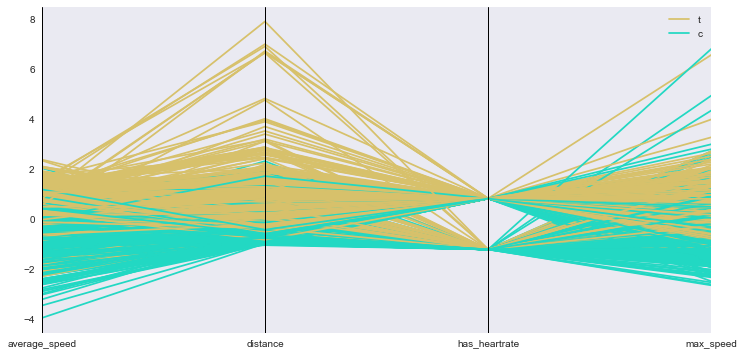

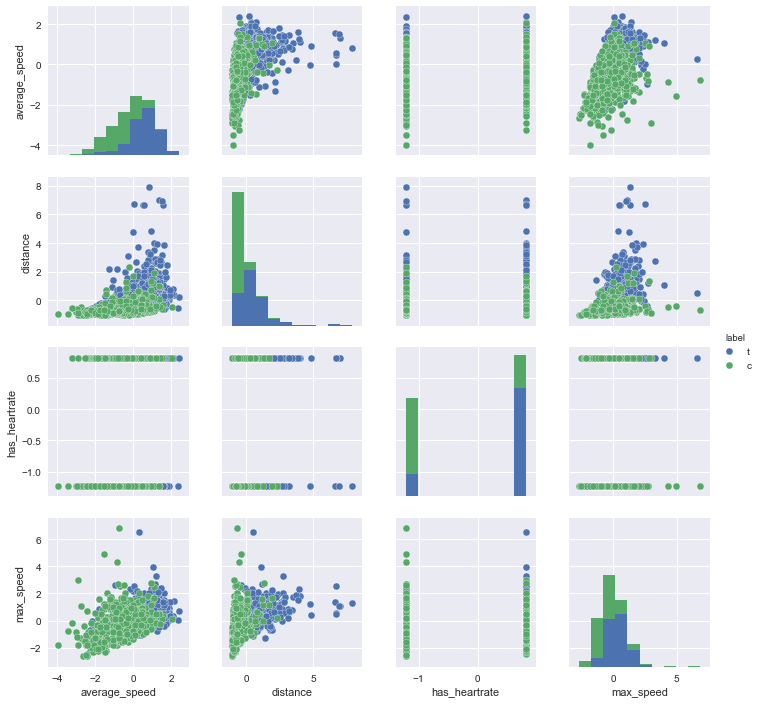

In [8]:
f, ax = plt.subplots(1, figsize=(12,6))
pd.plotting.parallel_coordinates(df_train, 'label', ax=ax)
ax = sns.pairplot(df_train, hue='label')

## Perform PCA analysis and visualize the ordered features

* No vanishing dimensions in the transformed feature set hinting that we have not enough independent observations 
* Classification results are likely to be dominated by the strong first component. This is also confirmed by the pairwise plot, where only first component shows strong separation in **mean** between classes
* The rest of the components do not appear to be separable meaning we are most likely have a 1-feature classifier. This is confirmed by the parallel coordinates plot

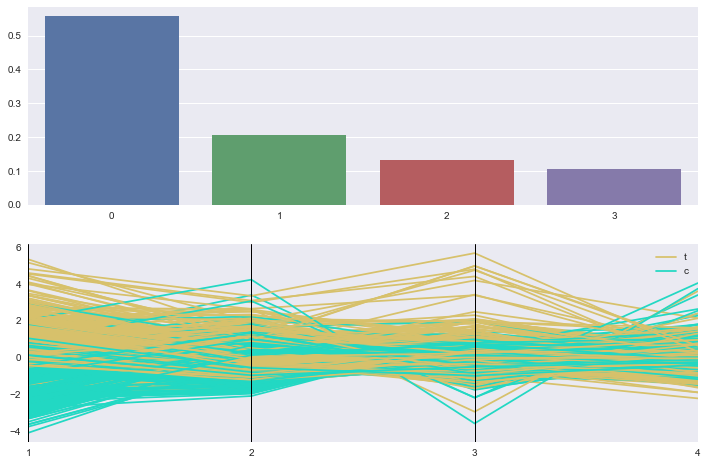

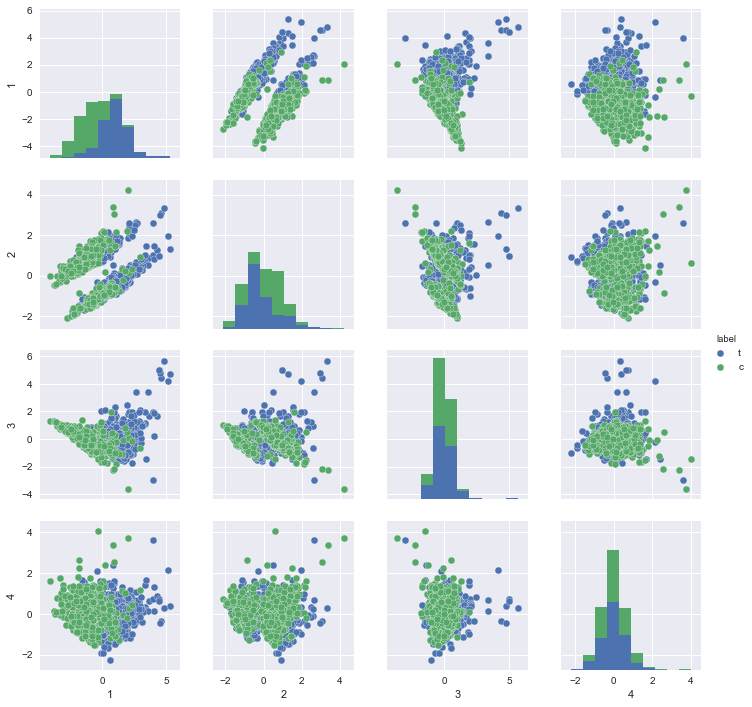

In [9]:
from sklearn.decomposition import PCA
pca = PCA().fit(train)
df_pca = pd.DataFrame(pca.fit_transform(train), columns=['1', '2', '3', '4'])
df_pca['label'] = y_train

f, ax = plt.subplots(2,1, figsize=(12,8))

sns.barplot(np.arange(len(pca.explained_variance_ratio_)),
            pca.explained_variance_ratio_, ax=ax[0])


pd.plotting.parallel_coordinates(df_pca, 'label', ax=ax[1])



ax = sns.pairplot(df_pca, hue='label')

## Cross validation analysis of the SVM

In [11]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1.0)
scores = model_selection.cross_val_score(clf, scaled_data,
                                         df_model['label'].values, 
                                         cv=5)
print('Accuracy: {:.2f} +/- {:.2f}'.format(scores.mean(), 2*scores.std()))

Accuracy: 0.86 +/- 0.04


## Classify with SVM

In [12]:
from sklearn import svm
clf = svm.SVC(kernel='linear').fit(train, y_train)
clf.score(test, y_test)

0.83720930232558144

## Verify fit on validation set and visualize the results

In [13]:
validation_set = pd.DataFrame(test, columns=training_features)

In [14]:
validation_set['label'] = y_test
validation_set['predictions'] = clf.predict(test)
validation_set['error'] = validation_set['label'] != validation_set['predictions']
validation_set.head()

,average_speed,distance,has_heartrate,max_speed,label,predictions,error
0,0.129005,0.846993,0.817686,0.524221,c,t,True
1,-0.167459,-0.769240,-1.222963,-0.630350,c,c,False
2,1.434427,-0.349089,0.817686,-0.232222,t,t,False
3,1.779210,0.058615,0.817686,0.962162,t,t,False
4,-0.652283,-0.893435,-1.222963,1.718605,c,c,False


## Confusion matrix

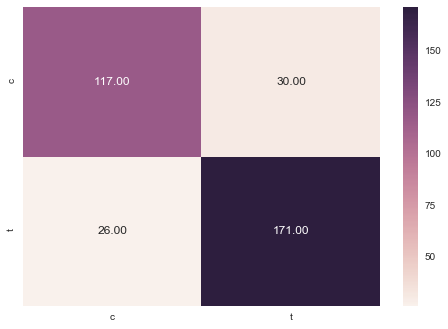

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,
                      validation_set['predictions'].values, ['c', 't'])
sns.heatmap(cm, annot=True, fmt='.2f',
            xticklabels=['c', 't'],
            yticklabels=['c', 't'])

In [16]:
def decision_boundary(clf, range_x=(-6.0, 5.0)):
    w = clf.coef_[0]
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(range_x[0], range_x[1])
    yy = a * xx - (clf.intercept_[0]) / w[1]
    return (xx, yy)

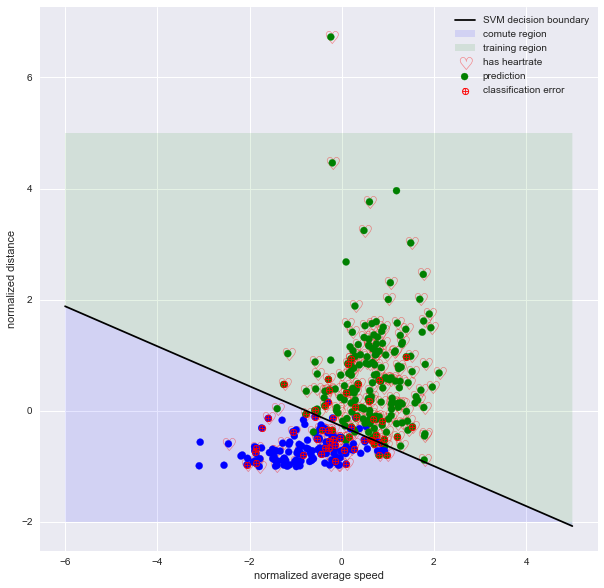

In [17]:
(xx, yy) = decision_boundary(clf)
colors={'c':'b', 't':'g'}

f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(xx, yy, 'k-')

ax.fill_between(xx, -2.0, yy,
               facecolor='blue',
               alpha=0.1)
ax.fill_between(xx, yy, 5.0,
               facecolor='green',
               alpha=0.1)

X='average_speed'
Y='distance'

## plot hearts
ax.scatter(x=validation_set.loc[df_test['has_heartrate']>0, X],
            y=validation_set.loc[df_test['has_heartrate']>0,  Y],
            marker=r'$\heartsuit$',
            s=200,
            facecolor='red',
            edgecolor='red',
            alpha=0.3)

ax.scatter(x=validation_set[X],
          y=validation_set[Y],
          c =validation_set['predictions'].map(colors))



ax.scatter(x=validation_set.loc[validation_set['error'], X],
           y=validation_set.loc[validation_set['error'],  Y],
           marker=r'$\bigoplus$',
           c='red')

plt.xlabel('normalized average speed')
plt.ylabel('normalized distance')
plt.legend(['SVM decision boundary', 'comute region', 'training region',
            'has heartrate', 'prediction', 'classification error'])

f.savefig('training_comute_svm_classifier.png')

## Run prediction on the full dataset

In [18]:
# scale features
f_scaled = scaler.fit_transform(df[training_features])
# run the classifier
df['predictions'] = clf.predict(f_scaled)

df.head()

,average_speed,commute,device_watts,distance,has_heartrate,id,max_speed,label,predictions
0,7.113,False,False,28859.1,False,1000003431,11.0,nc,c
1,8.232,False,False,73745.5,False,1000004535,15.6,nc,t
2,7.833,False,False,29734.7,False,1000036095,20.6,nc,c
3,4.882,False,False,39903.3,True,1000045152,13.5,nc,c
4,8.094,False,False,55461.9,True,1000057924,13.0,nc,t


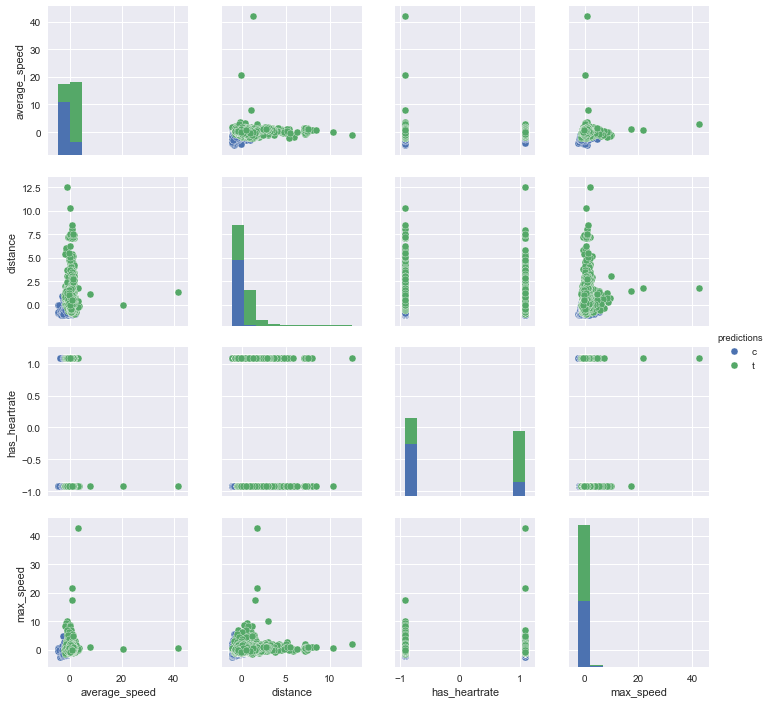

In [19]:
df_pred = pd.DataFrame(f_scaled, columns=training_features)
df_pred['predictions'] = df['predictions']
ax = sns.pairplot(df_pred, hue='predictions')

In [20]:
df[['id', 'predictions']].to_csv('berlin_v1.csv', index=False, float_format='%s')
df[['id', 'predictions']].to_json('berlin_v1.json', orient='records')

## Clustering using Kmeans

In [ ]:
# from sklearn import metrics
# from sklearn.cluster import KMeans

# estimator = KMeans(init='k-means++', n_clusters=2)
# estimator.fit(df_reduced)

# estimator.labels_
# df_reduced['labels'] = estimator.labels_
# df_reduced['commute'] = df['commute']

## Plotting results

In [ ]:
# color = {0: 'green', 1: 'blue'}
# mark = {0: 'c', 1: 't'}

# miss = df_reduced['labels'].astype(bool) & df_reduced['commute']

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(x=df_reduced[0],
#            y=df_reduced[1],
#            c=[color[x] for x in df_reduced['labels']])
# ax.hold=True
# ax.scatter(x=df_reduced[0].loc[miss],
#            y=df_reduced[1].loc[miss],
#            c='red',
#            marker='x')


# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs=df_reduced[0],
#            ys=df_reduced[1],
#            zs=df_reduced[2],
#            c=[color[x] for x in df_reduced['labels']])